In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree
import pickle

from sklearn.linear_model import LogisticRegression

RSEED = 42

# Preprocessing

## Functions

In [74]:
def dropCols(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        "country",
        "is_starrable",
        'converted_pledged_amount',
        'pledged',
        'category_slug',
        'disable_communication',
        'usd_pledged',
        "backers_count",
        "staff_pick",
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

def toDay(time_delta):
    return round(time_delta/3600/24,2)

def dateTimeUpdate(df):
    campaign_length = df.deadline - df.created_at
    campaign_length = campaign_length.apply(toDay)
    campaign_length.name = "campaign_length"
    
    time_until_launch = df.launched_at - df.created_at
    time_until_launch = time_until_launch.apply(toDay)
    time_until_launch.name = "time_until_launch"
    
    time_launch2state = df.state_changed_at - df.launched_at
    time_launch2state = time_launch2state.apply(toDay)
    time_launch2state.name = "time_launch2state"
    
    time_state2deadline = df.deadline - df.state_changed_at
    time_state2deadline = time_state2deadline.apply(toDay)
    time_state2deadline.name = "time_state2deadline"
    
    time_launch2deadline = df.deadline - df.launched_at
    time_launch2deadline = time_launch2deadline.apply(toDay)
    time_launch2deadline.name = "time_launch2deadline"
    
    df = pd.concat([df, 
                    campaign_length,
                    time_until_launch, 
                    #time_launch2state,
                    #time_state2deadline,
                    #time_launch2deadline
                   ],
                  axis = 1
                  )
    df.drop([
        "created_at",
        "deadline",
        "launched_at",
        "state_changed_at",
            ],
        axis =1,
        inplace=True
    )
    return df


## Load data, drop unnecessary columns

In [3]:
df = pd.read_csv('data/df_clean.csv')
df = dropCols(df)
df = dateTimeUpdate(df)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()
#df.goal = np.log10(df.goal)
df

,goal,state,category_name,cgrouped,campaign_length,time_until_launch,time_state2deadline
0,5000.0,failed,Woodworking,Other,24.36,1.36,0.00
1,30000.0,successful,Video Games,US,304.63,274.58,0.00
2,100000.0,successful,Wearables,US,76.31,40.52,-0.00
3,6500.0,successful,Indie Rock,US,74.59,41.10,-0.00
4,20000.0,canceled,Farms,US,757.56,727.56,11.85
...,...,...,...,...,...,...,...
163613,2500.0,successful,Hardware,GB,45.32,15.32,0.00
163614,20000.0,failed,Nature,US,31.05,0.06,0.00
163615,6000.0,failed,Gadgets,US,106.39,73.41,-0.00
163616,1000.0,failed,Radio & Podcasts,US,32.57,2.57,0.00


In [4]:
#df.describe()

,goal,campaign_length,time_until_launch,time_state2deadline
count,1.636180e+05,163618.000000,163618.000000,163618.000000
mean,5.327383e+04,79.451036,46.566058,1.881082
std,1.247722e+06,129.162995,128.331440,8.084102
min,1.000000e-02,1.020000,0.000000,-48.040000
25%,1.500000e+03,32.960000,2.790000,0.000000
50%,5.000000e+03,46.580000,10.695000,0.000000
75%,1.500000e+04,71.980000,35.510000,0.000000
max,1.000000e+08,3333.570000,3303.570000,88.190000


<AxesSubplot:xlabel='time_state2deadline', ylabel='goal'>

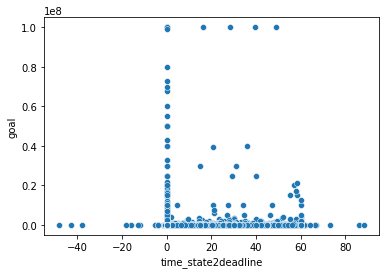

In [5]:
#sns.scatterplot(data = df, x= "time_state2deadline",y="goal" )
#plt.xscale("log")

## Define categorical and numerical columns

In [6]:
cat_features = list(df.columns[df.dtypes=='category'])
cat_features.remove('state')
cat_features

['category_name', 'cgrouped']

In [7]:
num_features = list(df.columns[df.dtypes!='category'])
num_features

['goal', 'campaign_length', 'time_until_launch', 'time_state2deadline']

## Define training data

Targets will only be "failed" and "successful" because, only these are purely market driven classes and therefore can be best related to the features. To predict for example "cancelled" more insights into the founders' business would be necessary.

In [8]:
X = df[(df['state']=='failed') | (df['state']=='successful')].drop("state", axis=1)
y = df[(df['state']=='failed') | (df['state']=='successful')]["state"]
print(f"fearture Rows: {X.shape[0]} \nfeature columns: {X.shape[1]}")
print(f"target rows: {y.shape[0]}")

fearture Rows: 151867 
feature columns: 6
target rows: 151867


In [9]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(["failed","successful"])
print("before: \n{}".format(np.array(y[:10])))
y = label_encoder.transform(y)
print("-----"*10)
print("after: \n{}".format(y[:10]))

before: 
['failed' 'successful' 'successful' 'successful' 'successful' 'successful'
 'successful' 'successful' 'successful' 'failed']
--------------------------------------------------
after: 
[0 1 1 1 1 1 1 1 1 0]


## Split the training data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=RSEED)
X_train, X_train_alt, y_train, y_train_alt = train_test_split(X_train, y_train, train_size=0.1,stratify=y_train, random_state=RSEED)

## Setup the preprocessing pipeline

In [11]:
# Pipeline for numerical features 
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

#preprocess validationData
preprocessor.fit(X_train)
X_test = preprocessor.transform(X_test)

#extract feature names
cat_cols= preprocessor.transformers_[1][1].named_steps["1hot"].get_feature_names(cat_features)
features = list(num_features) + list(cat_cols)

# Logistic Regression

In [76]:
# LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

#Grid search Parameters
param_logreg = {"logreg__penalty":['l2',"elasticnet","l1"],
                "logreg__dual":[False],
                "logreg__tol":[0.01, 0.1, 1, 10],
                "logreg__C":[0.1, 1.0, 10, 100],
                "logreg__fit_intercept":[True],
                "logreg__intercept_scaling":[1],
                "logreg__class_weight":[None],
                "logreg__random_state":[RSEED],
                "logreg__solver":['lbfgs'],
                "logreg__max_iter":[100,1000,10000],
                "logreg__multi_class":['auto'],
                "logreg__verbose":[0],
                "logreg__warm_start":[False],
                "logreg__n_jobs":[None],
                "logreg__l1_ratio":[None],
               }

grid_logreg = GridSearchCV(pipe_logreg,
                           param_grid=param_logreg,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [14]:
grid_logreg.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [15]:
grid_logreg.best_params_;

In [16]:
logreg_model = grid_logreg.best_estimator_['logreg']
y_log_pred_test = logreg_model.predict(X_test)
print(sm.classification_report(y_test, y_log_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73     13348
           1       0.80      0.73      0.77     17026

    accuracy                           0.75     30374
   macro avg       0.75      0.75      0.75     30374
weighted avg       0.75      0.75      0.75     30374



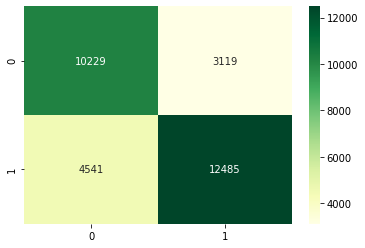

In [17]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_log_pred_test), annot=True, cmap='YlGn', fmt='d');

In [18]:
filename = './models/LogRegModel.sav'
pickle.dump(logreg_model, open(filename, 'wb'))

# KNN

In [77]:
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

#Grid search Parameters
param_knn = {
            "knn__n_neighbors":[5,20,50],
            "knn__weights":['uniform',"distance"],
            "knn__algorithm":['auto'],
            "knn__leaf_size":[30],
            "knn__p":[2,1,100],
            "knn__metric":['minkowski'],
            "knn__metric_params":[None],
            "knn__n_jobs":[None],
               }

grid_knn = GridSearchCV(pipe_knn,
                           param_grid=param_knn,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [20]:
grid_knn.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [21]:
grid_knn.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 20,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [22]:
knn_model = grid_knn.best_estimator_['knn']
y_knn_pred_test = knn_model.predict(X_test)
print(sm.classification_report(y_test, y_knn_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70     13348
           1       0.77      0.73      0.75     17026

    accuracy                           0.73     30374
   macro avg       0.73      0.73      0.73     30374
weighted avg       0.73      0.73      0.73     30374



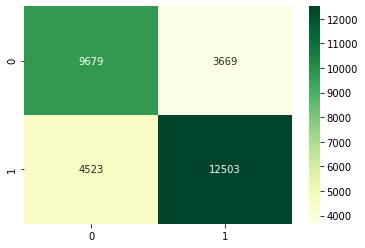

In [23]:
sns.heatmap(confusion_matrix(y_test, y_knn_pred_test), annot=True, cmap='YlGn', fmt='d');

In [24]:
filename = './models/KNNModel.sav'
pickle.dump(knn_model, open(filename, 'wb'))

# Naive Bayes

In [25]:
pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', BernoulliNB())
])

#Grid search Parameters
param_nb = {'nb__alpha': [1,3,10,30],
            "nb__binarize" : [0.0],
            "nb__fit_prior":[True],
            "nb__class_prior":[None]
            }


grid_nb = GridSearchCV(pipe_nb,
                           param_grid=param_nb,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [26]:
grid_nb.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [27]:
grid_nb.best_params_

{'nb__alpha': 1,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [28]:
nb_model = grid_nb.best_estimator_['nb']
y_nb_pred_test = nb_model.predict(X_test)
print(sm.classification_report(y_test, y_nb_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72     13348
           1       0.80      0.72      0.76     17026

    accuracy                           0.74     30374
   macro avg       0.74      0.74      0.74     30374
weighted avg       0.75      0.74      0.74     30374



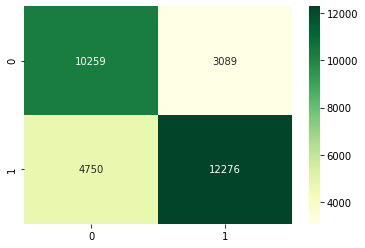

In [29]:
sns.heatmap(confusion_matrix(y_test, y_nb_pred_test), annot=True, cmap='YlGn', fmt='d');

In [30]:
filename = './models/NaiveBayesModel.sav'
pickle.dump(nb_model, open(filename, 'wb'))

# Decision Tree

In [31]:
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier())
])

#Grid search Parameters
param_dt = {"dt__criterion":['gini',"entropy"],
            "dt__splitter":['best'],
            "dt__max_depth":[None,5,8,10,15,20],
            "dt__min_samples_split":[10,50,100],
            "dt__min_samples_leaf":[2],
            "dt__min_weight_fraction_leaf":[0.0],
            "dt__max_features":[None],
            "dt__random_state":[RSEED],
            "dt__max_leaf_nodes":[None],
            "dt__min_impurity_decrease":[0.0],
            "dt__min_impurity_split":[None],
            "dt__class_weight":[None],
            "dt__ccp_alpha":[0.0],
            }

grid_dt = GridSearchCV(pipe_dt,
                           param_grid=param_dt,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [32]:
grid_dt.fit(X_train,y_train);

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [33]:
grid_dt.best_params_

{'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 50,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [34]:
dt_model = grid_dt.best_estimator_["dt"]
y_dt_pred_test = dt_model.predict(X_test)
print(sm.classification_report(y_test, y_dt_pred_test))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67     13348
           1       0.74      0.73      0.74     17026

    accuracy                           0.71     30374
   macro avg       0.70      0.70      0.70     30374
weighted avg       0.71      0.71      0.71     30374



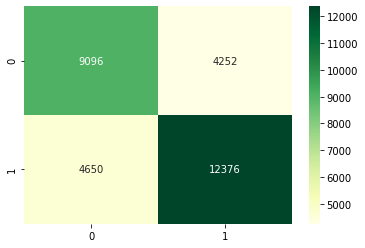

In [35]:
sns.heatmap(confusion_matrix(y_test, y_dt_pred_test), annot=True, cmap='YlGn', fmt='d');

In [36]:
fi = pd.DataFrame({'feature': features,
                   'importance': dt_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
2,time_until_launch,0.193298
0,goal,0.176090
1,campaign_length,0.113464
43,category_name_Documentary,0.032860
152,category_name_Video Games,0.027346
129,category_name_Rock,0.025617
133,category_name_Shorts,0.022822
117,category_name_Product Design,0.022231
99,category_name_Nonfiction,0.020848
58,category_name_Fiction,0.020801


In [37]:
from graphviz import render
from graphviz import Source

tree.export_graphviz(dt_model,
                     out_file="tree3.dot",
                     feature_names = features, 
                     class_names=["failed", "sucessful"],
                     filled = True)
# Convert a .dot file to .png

render("dot", "png", "tree3.dot")
# To render an existing file in a notebook

#Source.from_file("tree3.dot")

'tree3.dot.png'

In [39]:
filename = './models/DecisionTreeModel.sav'
pickle.dump(dt_model, open(filename, 'wb'))

# SVC

In [40]:
pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

#Grid search Parameters
param_svc = {
            "svc__C":[1.0, 0.1, 10.0, 100.0],
            "svc__kernel":['rbf'],
            "svc__degree":[3],
            "svc__gamma":['scale',"auto"],
            "svc__coef0":[0.0],
            "svc__shrinking":[True],
            "svc__probability":[False],
            "svc__tol":[0.01,1e-4,1e-3,0.1],
            "svc__cache_size":[200],
            "svc__class_weight":[None],
            "svc__verbose":[False],
            "svc__max_iter":[-1],
            "svc__decision_function_shape":['ovr'],
            "svc__break_ties":[False],
            "svc__random_state":[RSEED],
            }

grid_svc = GridSearchCV(pipe_svc,
                           param_grid=param_svc,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [41]:
grid_svc.fit(X_train,y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [42]:
grid_svc.best_params_

{'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 42,
 'svc__shrinking': True,
 'svc__tol': 0.01,
 'svc__verbose': False}

In [43]:
svc_model = grid_svc.best_estimator_["svc"]
y_svc_pred_test = svc_model.predict(X_test)
print(sm.classification_report(y_test,y_svc_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73     13348
           1       0.81      0.70      0.75     17026

    accuracy                           0.74     30374
   macro avg       0.74      0.75      0.74     30374
weighted avg       0.75      0.74      0.74     30374



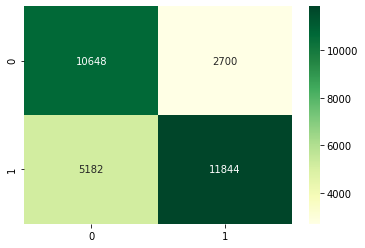

In [44]:
sns.heatmap(confusion_matrix(y_test, y_svc_pred_test), annot=True, cmap='YlGn', fmt='d');

In [45]:
filename = './models/SVCModel.sav'
pickle.dump(svc_model, open(filename, 'wb'))

# Random Forest

In [46]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

#Grid search Parameters
param_rf = {
            "rf__n_estimators":[100, 500, 1000],
            "rf__criterion":['gini',"entropy"],
            "rf__max_depth":[None,1,2,5,10],
            "rf__min_samples_split":[2,10,50],
            "rf__min_samples_leaf":[1],
            "rf__min_weight_fraction_leaf":[0.0],
            "rf__max_features":['auto',"sqrt"],
            "rf__max_leaf_nodes":[None],
            "rf__min_impurity_decrease":[0.0],
            "rf__min_impurity_split":[None],
            "rf__bootstrap":[True],
            "rf__oob_score":[False],
            "rf__n_jobs":[None],
            "rf__random_state":[RSEED],
            "rf__verbose":[0],
            "rf__warm_start":[False],
            "rf__class_weight":[None],
            "rf__ccp_alpha":[0.0],
            "rf__max_samples":[None],
            }

grid_rf = GridSearchCV(pipe_rf,
                           param_grid=param_rf,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [47]:
grid_rf.fit(X_train,y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [48]:
grid_rf.best_params_

{'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 10,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [49]:
rf_model = grid_rf.best_estimator_["rf"]
y_rf_pred_test = rf_model.predict(X_test)
print(sm.classification_report(y_test,y_rf_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71     13348
           1       0.77      0.79      0.78     17026

    accuracy                           0.75     30374
   macro avg       0.75      0.75      0.75     30374
weighted avg       0.75      0.75      0.75     30374



In [50]:
fi = pd.DataFrame({'feature': features,
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
0,goal,0.184374
2,time_until_launch,0.128189
1,campaign_length,0.076514
155,category_name_Web,0.031711
99,category_name_Nonfiction,0.026380
43,category_name_Documentary,0.026364
129,category_name_Rock,0.024587
34,category_name_Country & Folk,0.024416
58,category_name_Fiction,0.023091
152,category_name_Video Games,0.022853


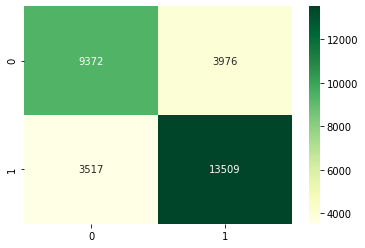

In [51]:
sns.heatmap(confusion_matrix(y_test, y_rf_pred_test), annot=True, cmap='YlGn', fmt='d');

In [52]:
filename = './models/RandomForestModel.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# AdaBoost

In [69]:
pipe_ab = Pipeline([
    ('preprocessor', preprocessor),
    ('ab', AdaBoostClassifier())
])

#Grid search Parameters
param_ab = {            
            "ab__base_estimator":[None, LogisticRegression(),BernoulliNB()],
            "ab__n_estimators":[20,50,100],
            "ab__learning_rate":[0.1,1.0,10],
            "ab__algorithm":['SAMME.R'],
            "ab__random_state":[RSEED],
            }

grid_ab = GridSearchCV(pipe_ab,
                           param_grid=param_ab,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [70]:
grid_ab.fit(X_train,y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [71]:
grid_ab.best_params_

{'ab__algorithm': 'SAMME.R',
 'ab__base_estimator': None,
 'ab__learning_rate': 0.5,
 'ab__n_estimators': 50,
 'ab__random_state': 42}

In [72]:
ab_model = grid_ab.best_estimator_["ab"]
y_ab_pred_test = ab_model.predict(X_test)
print(sm.classification_report(y_test,y_ab_pred_test))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     13348
           1       0.78      0.76      0.77     17026

    accuracy                           0.74     30374
   macro avg       0.74      0.74      0.74     30374
weighted avg       0.74      0.74      0.74     30374



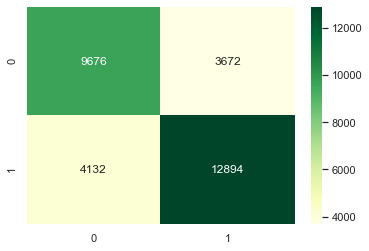

In [73]:
sns.heatmap(confusion_matrix(y_test, y_ab_pred_test), annot=True, cmap='YlGn', fmt='d');

In [58]:
filename = './models/AdaBoostModel.sav'
pickle.dump(ab_model, open(filename, 'wb'))

## Get data for ROC Curves

In [59]:
X_train_preprocessed = preprocessor.transform(X_train)

#Logistic Regression
y_logreg_train_probs = logreg_model.predict_proba(X_train_preprocessed)[:, 1]
y_logreg_test_probs = logreg_model.predict_proba(X_test)[:, 1]
y_logreg_pred_train = logreg_model.predict(X_train_preprocessed)
y_logreg_pred_test = logreg_model.predict(X_test)

#KNN
y_knn_train_probs = knn_model.predict_proba(X_train_preprocessed)[:, 1]
y_knn_test_probs = knn_model.predict_proba(X_test)[:, 1]
y_knn_pred_train = knn_model.predict(X_train_preprocessed)
y_knn_pred_test = knn_model.predict(X_test)

#Naive Bayes
y_nb_train_probs = nb_model.predict_proba(X_train_preprocessed)[:, 1]
y_nb_test_probs = nb_model.predict_proba(X_test)[:, 1]
y_nb_pred_train = nb_model.predict(X_train_preprocessed)
y_nb_pred_test = nb_model.predict(X_test)

#Decision Tree
y_dt_train_probs = dt_model.predict_proba(X_train_preprocessed)[:, 1]
y_dt_test_probs = dt_model.predict_proba(X_test)[:, 1]
y_dt_pred_train = dt_model.predict(X_train_preprocessed)
y_dt_pred_test = dt_model.predict(X_test)

#SVC
#y_svc_train_probs = svc_model.predict_proba(X_train_preprocessed)[:, 1]
#y_svc_test_probs = svc_model.predict_proba(X_test)[:, 1]
y_svc_pred_train = svc_model.predict(X_train_preprocessed)
y_svc_pred_test = svc_model.predict(X_test)

#Random Forest
y_rf_train_probs = rf_model.predict_proba(X_train_preprocessed)[:, 1]
y_rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
y_rf_pred_train = rf_model.predict(X_train_preprocessed)
y_rf_pred_test = rf_model.predict(X_test)

#Ada Boost
y_ab_train_probs = ab_model.predict_proba(X_train_preprocessed)[:, 1]
y_ab_test_probs = ab_model.predict_proba(X_test)[:, 1]
y_ab_pred_train = ab_model.predict(X_train_preprocessed)
y_ab_pred_test = ab_model.predict(X_test)

ROC curves to be done later

In [60]:
df_ev = pd.DataFrame(np.array([
    [
        sm.accuracy_score(y_test,y_logreg_pred_test),
        sm.accuracy_score(y_test,y_knn_pred_test),
        sm.accuracy_score(y_test,y_nb_pred_test),
        sm.accuracy_score(y_test,y_dt_pred_test),
        sm.accuracy_score(y_test,y_svc_pred_test),
        sm.accuracy_score(y_test,y_rf_pred_test),
        sm.accuracy_score(y_test,y_ab_pred_test),
    ],
    [
        sm.precision_score(y_test,y_logreg_pred_test),
        sm.precision_score(y_test,y_knn_pred_test),
        sm.precision_score(y_test,y_nb_pred_test),
        sm.precision_score(y_test,y_dt_pred_test),
        sm.precision_score(y_test,y_svc_pred_test),
        sm.precision_score(y_test,y_rf_pred_test),
        sm.precision_score(y_test,y_ab_pred_test),
    ],
    [
        sm.recall_score(y_test,y_logreg_pred_test),
        sm.recall_score(y_test,y_knn_pred_test),
        sm.recall_score(y_test,y_nb_pred_test),
        sm.recall_score(y_test,y_dt_pred_test),
        sm.recall_score(y_test,y_svc_pred_test),
        sm.recall_score(y_test,y_rf_pred_test),
        sm.recall_score(y_test,y_ab_pred_test),
    ],
    [
        sm.f1_score(y_test,y_logreg_pred_test),
        sm.f1_score(y_test,y_knn_pred_test),
        sm.f1_score(y_test,y_nb_pred_test),
        sm.f1_score(y_test,y_dt_pred_test),
        sm.f1_score(y_test,y_svc_pred_test),
        sm.f1_score(y_test,y_rf_pred_test),
        sm.f1_score(y_test,y_ab_pred_test),
    ],
    ]),#.reshape(7,4),
    index=["Accuracy","Precision","Recall","F1"],
    columns=["logreg","knn","nb","dt","svc","rf","ab"]
)
#df_ev = round(df_ev,2)

In [61]:
#df_ev = df_ev.transpose()

<AxesSubplot:>

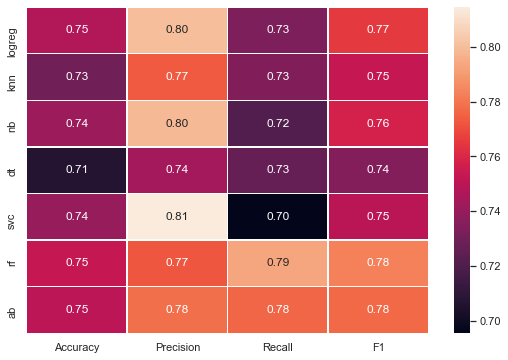

In [62]:
sns.set_theme()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_ev.transpose(), annot=True, fmt=".2f", linewidths=.5, ax= ax)

# Ensemble

In [63]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=RSEED)),
    #('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state=RSEED)),
    ("nb", BernoulliNB())
]

pipe_stack = Pipeline([
    ('preprocessor', preprocessor),
    ('stack', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
])

In [64]:
#pipe_stack.fit(X_train, y_train)

In [65]:
#pipe_stack.get_params()

In [66]:
#y_stack_pred_test = pipe_stack.predict(X_test)
#y_stack_pred_test

In [67]:
#print(sm.classification_report(y_test,y_stack_pred_test))

In [68]:
#model_tree = pickle.load(open("./models/DecisionTreeModel.sav", 'rb'))
